In [2]:
# Imports
import pandas as pd
import os
import locale
from matplotlib import pyplot as plt
import numpy as np
from prophet import Prophet

locale.setlocale(locale.LC_ALL, 'fr_FR');

In [3]:
# Chemins
path = None
path = os.path.dirname(os.getcwd())
print("Le chemin est "+path)

pdf_dir = os.path.join(path, 'data', 'data_cine_pdf')
raw_data_path = os.path.join(path, 'data', 'raw_data', 'df_raw.csv')
data_path = os.path.join(path, 'data', 'clean_data.csv')

Le chemin est C:\Users\A38579\PyCharmProjects\Cine_ML


In [4]:
# Recuperation des données
df = pd.read_csv(data_path, parse_dates=[['date', 'time']], dayfirst=True)

In [5]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25525 entries, 0 to 25524
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date_time         25525 non-null  datetime64[ns]
 1   Salle             25525 non-null  object        
 2   Film              25525 non-null  object        
 3   Version           25525 non-null  object        
 4   Relief            25525 non-null  object        
 5   Payants           23186 non-null  float64       
 6   Gratuits          3470 non-null   float64       
 7   Places libres     25495 non-null  float64       
 8   Taux remplissage  23260 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 1.8+ MB


In [6]:
df

,date_time,Salle,Film,Version,Relief,Payants,Gratuits,Places libres,Taux remplissage
0,2018-11-27 09:45:00,SALLE 6,L'île De Black Mór,FR,2D,136.0,10.0,142.0,"50,69%"
1,2018-11-27 10:55:00,SALLE 2,Diamant Noir,FR,2D,53.0,NaN,91.0,"36,81%"
2,2018-11-27 14:00:00,SALLE 2,"Sobibor, 14 Octobre 1943, 16 Heures",FR,2D,54.0,NaN,90.0,"37,50%"
3,2018-11-27 20:30:00,SALLE 1,Cold War,VO,2D,6.0,NaN,87.0,"6,45%"
4,2018-11-27 20:30:00,SALLE 2,Bohemian Rhapsody,VF,2D,64.0,NaN,80.0,"44,44%"
...,...,...,...,...,...,...,...,...,...
25520,2022-08-07 20:30:00,SALLE 2,Bullet Train,VF,2D,NaN,NaN,144.0,NaN
25521,2022-08-07 20:30:00,SALLE 4,Thor: Love And Thunder,VF,2D,NaN,NaN,93.0,NaN
25522,2022-08-07 20:30:00,SALLE 5,L'année Du Requin,FR,2D,NaN,NaN,114.0,NaN
25523,2022-08-07 20:40:00,SALLE 6,Les Minions 2 : Il était Une Fois Gru,VF,2D,NaN,NaN,288.0,NaN


### Description des données

- **Film** : Titre du film (chaîne de caractères)
- **Version** : Langue des dialogues ('_FR_' pour film français en langue originale, '_VF_' pour film étranger en langue française et '_VO_' pour film étranger en langue originale)
- **Relief** : Option supplémentaire ('_2D_' si l'option est désactivée, '_3D_' si l'option est activée)
- **Payants** : Nombre d'entrées vendues (valeur numérique)
- **Gratuits** : Nombre d'entrées gratuites (valeur numérique)
- **Places libres** : Nombre de places restantes dans la salle (valeur numérique)
- **Taux remplissage** : Niveau de remplissage de la salle (pourcentage, calculé par : (nombre d'entrées payantes + nombre d'entrées gratuites) / nombre de places)

### Nettoyage et preparation

In [7]:
# Creation de la nouvelle colonne 'Nombre entrees'
df['Nombre entrees'] = df[["Payants", "Gratuits"]].sum(axis=1)

In [8]:
# Nettoyage des nombres d'entrées à 0
# df = df[~(df['Nombre entrees'] == 0)].reset_index()

In [9]:
# Conversion en valeur numérique de la colonne 'Taux remplissage'
try:
    df['Taux remplissage'] = df['Taux remplissage'].str.rstrip('%').str.replace(',','.').astype('float')
except:
    print('Nothing to do')

In [10]:
df

,date_time,Salle,Film,Version,Relief,Payants,Gratuits,Places libres,Taux remplissage,Nombre entrees
0,2018-11-27 09:45:00,SALLE 6,L'île De Black Mór,FR,2D,136.0,10.0,142.0,50.69,146.0
1,2018-11-27 10:55:00,SALLE 2,Diamant Noir,FR,2D,53.0,NaN,91.0,36.81,53.0
2,2018-11-27 14:00:00,SALLE 2,"Sobibor, 14 Octobre 1943, 16 Heures",FR,2D,54.0,NaN,90.0,37.50,54.0
3,2018-11-27 20:30:00,SALLE 1,Cold War,VO,2D,6.0,NaN,87.0,6.45,6.0
4,2018-11-27 20:30:00,SALLE 2,Bohemian Rhapsody,VF,2D,64.0,NaN,80.0,44.44,64.0
...,...,...,...,...,...,...,...,...,...,...
25520,2022-08-07 20:30:00,SALLE 2,Bullet Train,VF,2D,NaN,NaN,144.0,NaN,0.0
25521,2022-08-07 20:30:00,SALLE 4,Thor: Love And Thunder,VF,2D,NaN,NaN,93.0,NaN,0.0
25522,2022-08-07 20:30:00,SALLE 5,L'année Du Requin,FR,2D,NaN,NaN,114.0,NaN,0.0
25523,2022-08-07 20:40:00,SALLE 6,Les Minions 2 : Il était Une Fois Gru,VF,2D,NaN,NaN,288.0,NaN,0.0


### Statistiques descriptives

In [11]:
# Dates
print("Le jeu de données commence le "+df['date_time'].min().strftime('%d %B %Y') + " et finit le "+df['date_time'].max().strftime('%d %B %Y'))

# Nombre de films
print(str(len(df['Film'].unique()))+" films ont été proposés")

Le jeu de données commence le 27 novembre 2018 et finit le 07 août 2022
1075 films ont été proposés


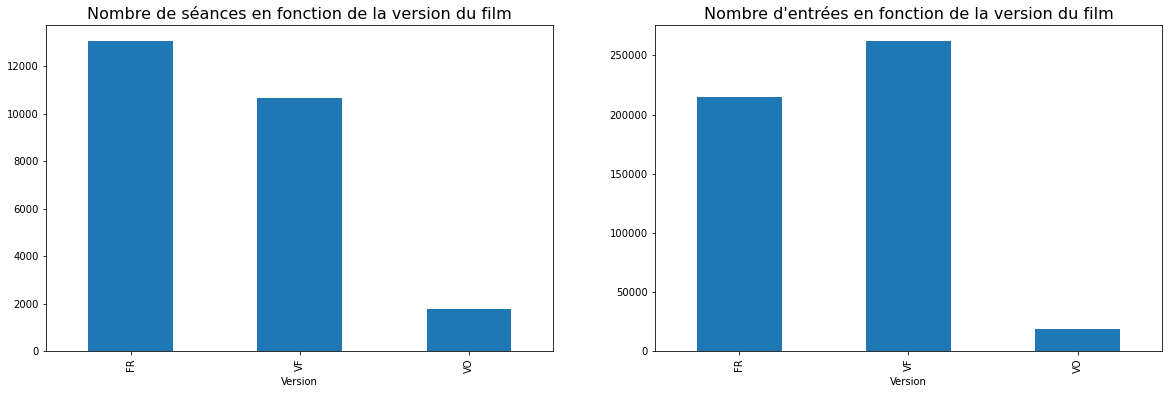

In [12]:
# Version
plt.subplot(1, 2, 1)
df['Version'].value_counts().plot(kind='bar',
                                  xlabel='Version');
plt.title('Nombre de séances en fonction de la version du film', fontsize=16);

plt.subplot(1, 2, 2)
df.groupby('Version').sum()['Nombre entrees'].plot(kind='bar',
                                                   figsize=(20, 6));
plt.title('Nombre d\'entrées en fonction de la version du film', fontsize=16);

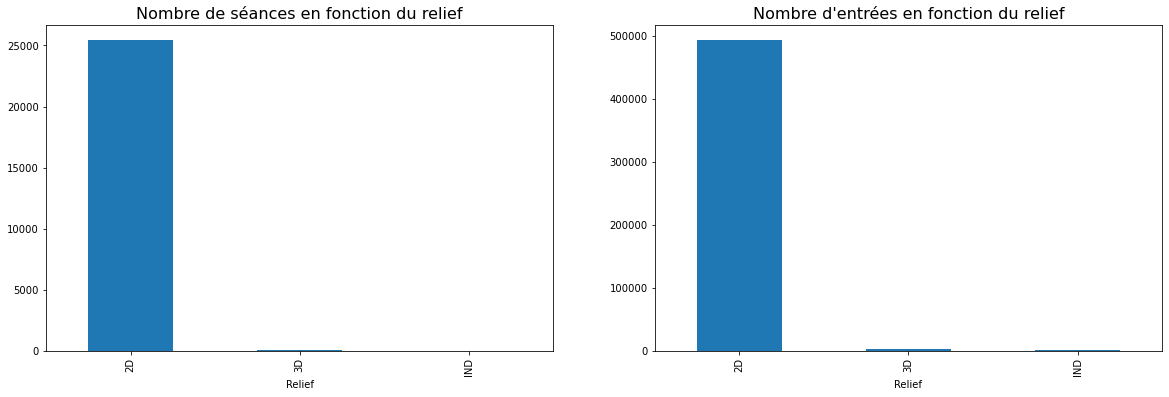

In [13]:
# Relief
plt.subplot(1, 2, 1)
df['Relief'].value_counts().plot(kind='bar',
                                  xlabel='Relief');
plt.title('Nombre de séances en fonction du relief', fontsize=16);

plt.subplot(1, 2, 2)
df.groupby('Relief').sum()['Nombre entrees'].plot(kind='bar',
                                                   figsize=(20, 6));
plt.title('Nombre d\'entrées en fonction du relief', fontsize=16);

In [14]:
# Taux remplissage
print("Le taux de remplissage moyen est de "+str(round(df['Taux remplissage'].mean(),2))+" %")

Le taux de remplissage moyen est de 14.12 %


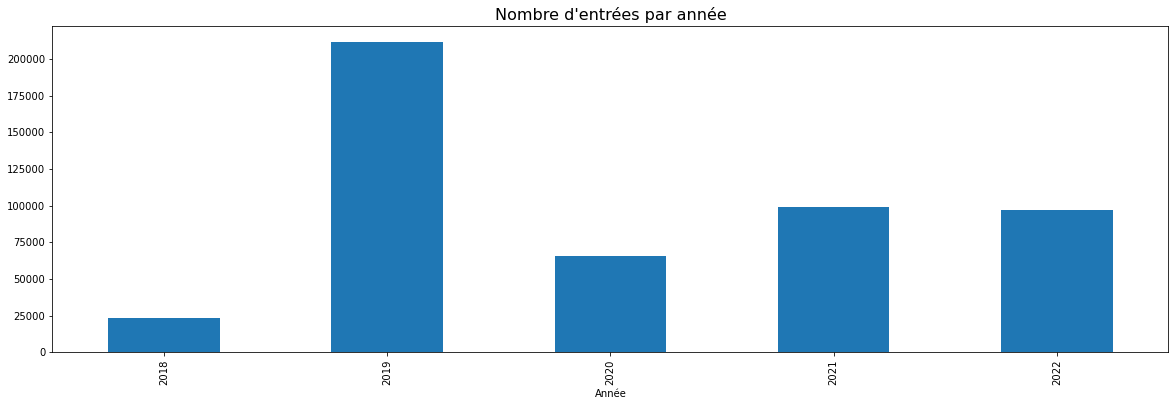

In [15]:
# Nombre d'entrées par année
df.groupby(df['date_time'].dt.year.astype(str)).sum()['Nombre entrees'].plot(kind='bar',
                                                                             figsize=(20, 6),
                                                                             xlabel='Année');
plt.title('Nombre d\'entrées par année', fontsize=16);

In [16]:
# Moyennes par salle
df.groupby('Salle').mean()

,Payants,Gratuits,Places libres,Taux remplissage,Nombre entrees
Salle,,,,,
SALLE 1,12.569029,2.431559,81.682944,13.825880,11.370722
SALLE 2,20.321539,2.845659,125.173421,14.381372,18.939501
SALLE 3,25.511640,3.326498,167.985899,13.536771,24.167880
SALLE 4,14.200473,2.305677,80.158835,15.498703,12.931941
SALLE 5,16.508282,2.468938,98.984572,14.721667,15.173862
SALLE 6,36.393869,2.968536,253.835064,12.811659,34.583173


In [17]:
# Moyennes par année
df.groupby(df['date_time'].dt.year).mean()

,Payants,Gratuits,Places libres,Taux remplissage,Nombre entrees
date_time,,,,,
2018,27.862745,3.317308,129.414221,18.651322,26.050790
2019,23.292713,2.707766,131.221075,15.531796,21.589111
2020,17.769788,2.641791,137.156567,12.539606,16.159990
2021,19.425511,2.776337,135.639816,12.891304,18.191266
2022,19.563476,2.935103,135.488706,13.218695,18.138993


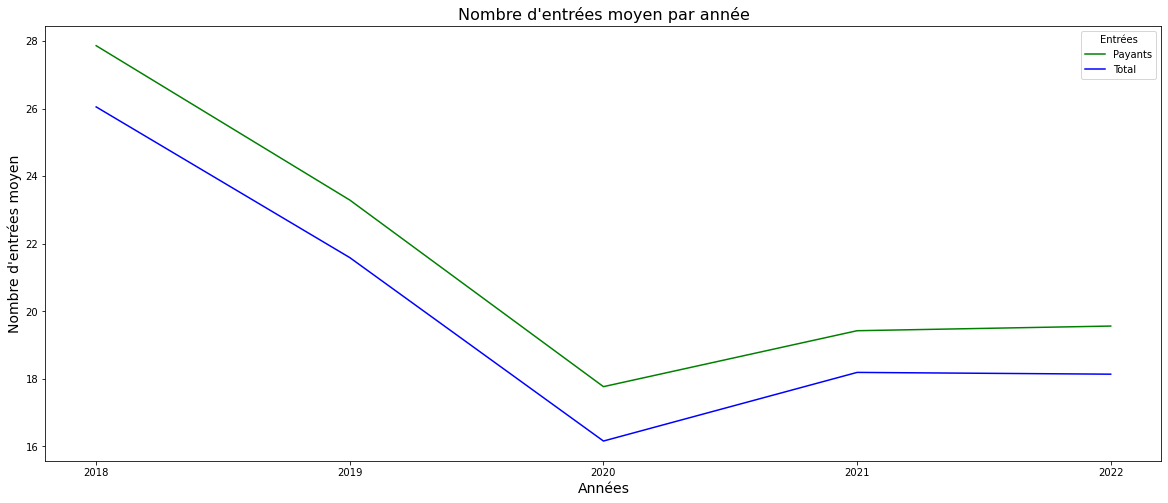

In [18]:
# Moyennes par année
plt.figure(figsize=(20, 8))
plt.plot(df.groupby(df['date_time'].dt.year.astype(str)).mean()['Payants'], label='Payants', color='green')
plt.plot(df.groupby(df['date_time'].dt.year.astype(str)).mean()['Nombre entrees'], label='Total', color='blue')

plt.legend(title='Entrées')

plt.ylabel('Nombre d\'entrées moyen', fontsize=14)
plt.xlabel('Années', fontsize=14)
plt.title('Nombre d\'entrées moyen par année', fontsize=16)


plt.show()

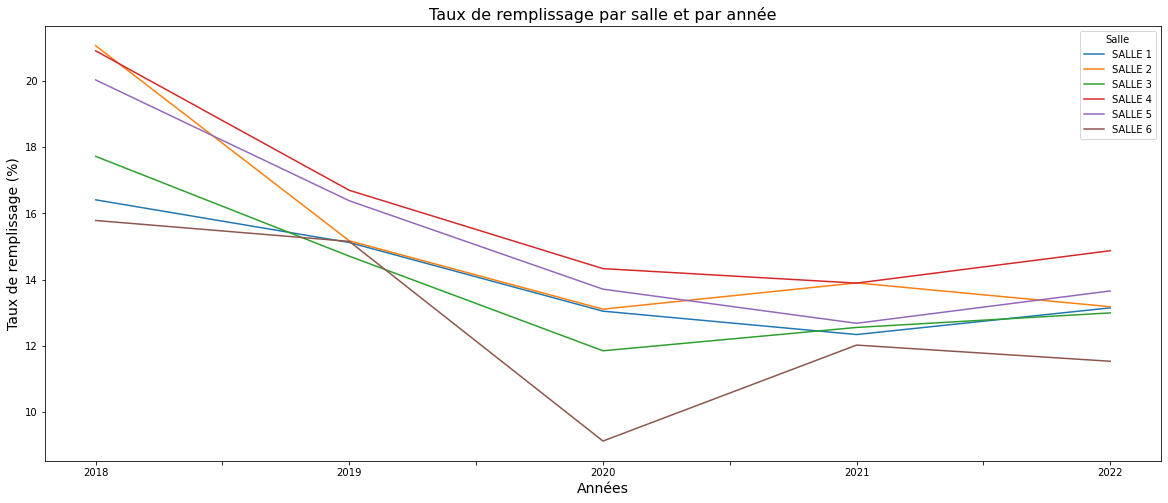

In [19]:
# Taux de remplissage par salle et par année
df.groupby(['Salle', df['date_time'].dt.year.astype(str)]).mean()['Taux remplissage'].unstack(level=0).plot(figsize=(20,8));

plt.ylabel('Taux de remplissage (%)', fontsize=14)
plt.xlabel('Années', fontsize=14)
plt.title('Taux de remplissage par salle et par année', fontsize=16)


plt.show();

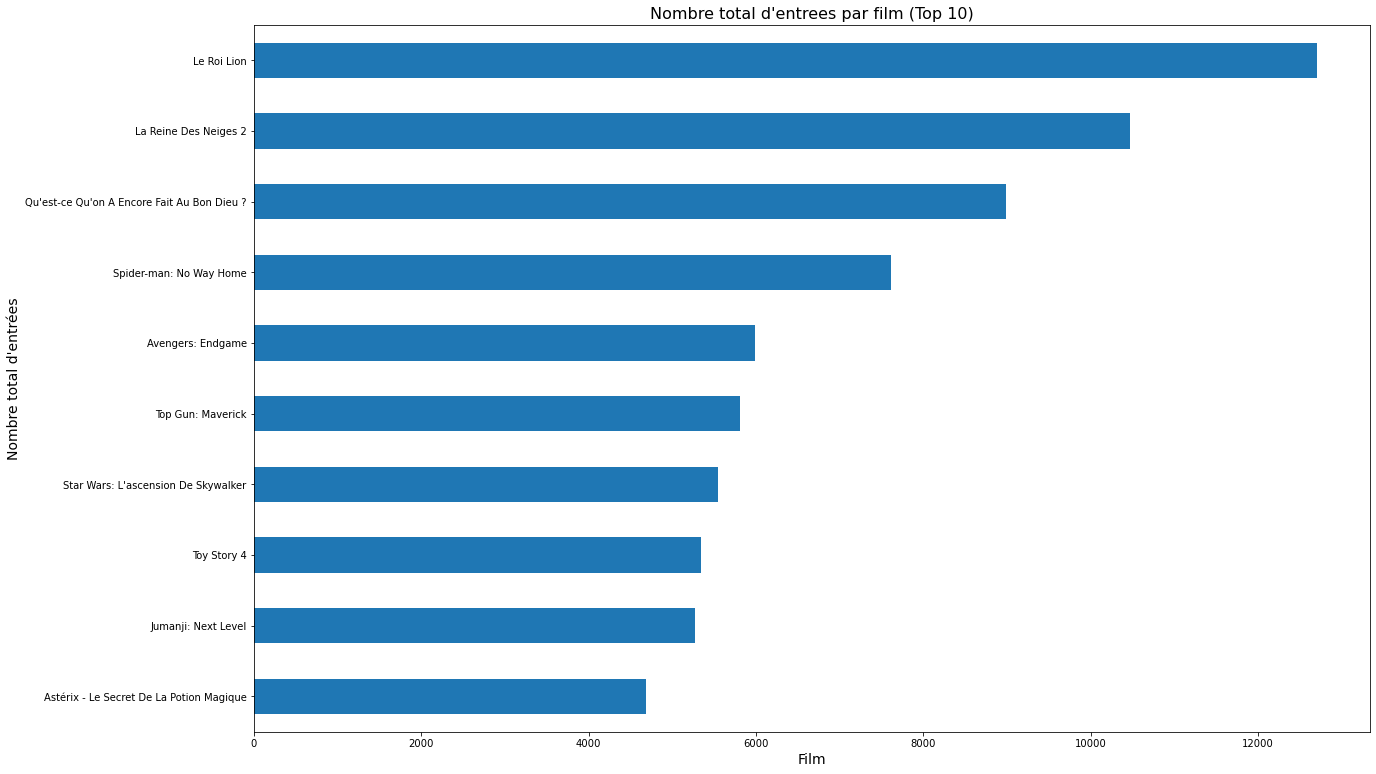

In [20]:
# Top nombre d'entrées par film
df.groupby('Film').sum()['Nombre entrees'].sort_values(ascending=True).tail(10).plot(kind='barh',figsize=(20,13));

plt.ylabel('Nombre total d\'entrées', fontsize=14)
plt.xlabel('Film', fontsize=14)
plt.title('Nombre total d\'entrees par film (Top 10)', fontsize=16)


plt.show();

### Analyse de la série temporelle

#### Modelisation

In [46]:
# Préparation données pour Prophet
df_prophet = pd.DataFrame()
df_prophet['ds'] = df["date_time"]
df_prophet['y'] = df['Nombre entrees']

In [47]:
# Aggrégation sur le time stamp
df_prophet= df_prophet.groupby(['ds']).sum()
df_prophet['ds'] = df_prophet.index
df_prophet = df_prophet.reindex(columns = ['ds', 'y'])

In [48]:
# Ajout de l'information jour de weekend/jour de semaine
def is_weekend(ds):
  date = pd.to_datetime(ds)
  return (date.dayofweek == 5 or date.dayofweek == 6)

df_prophet['weekend'] = df_prophet['ds'].apply(is_weekend)
df_prophet['weekday'] = ~df_prophet['ds'].apply(is_weekend)

In [49]:
# Réechantillonnage à la journée
# r = df_prophet.resample('1d')
# df_day = r.agg(np.sum)
# df_day['ds'] = df_day.index
# df_day = df_day.reindex(columns = ['ds', 'y'])
# df_day.plot('ds','y', figsize = (15,10))
# plt.show()

In [50]:
# Modélisation Prophet
model = Prophet(seasonality_mode='multiplicative')
model.add_seasonality(name='jour_de_weekend',period=1,fourier_order=3,condition_name='weekend')
model.add_seasonality(name='jour_de_semaine',period=1,fourier_order=3,condition_name='weekday')
model.add_country_holidays(country_name='FR')
model.fit(df_prophet)

In [52]:
forecast = model.predict()

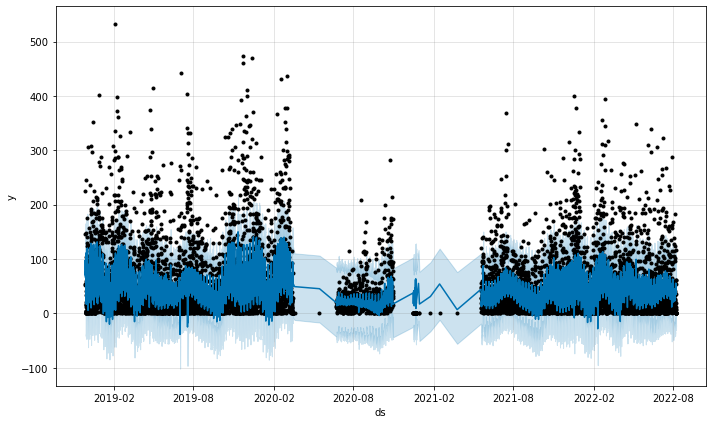

In [53]:
fig1 = model.plot(forecast)

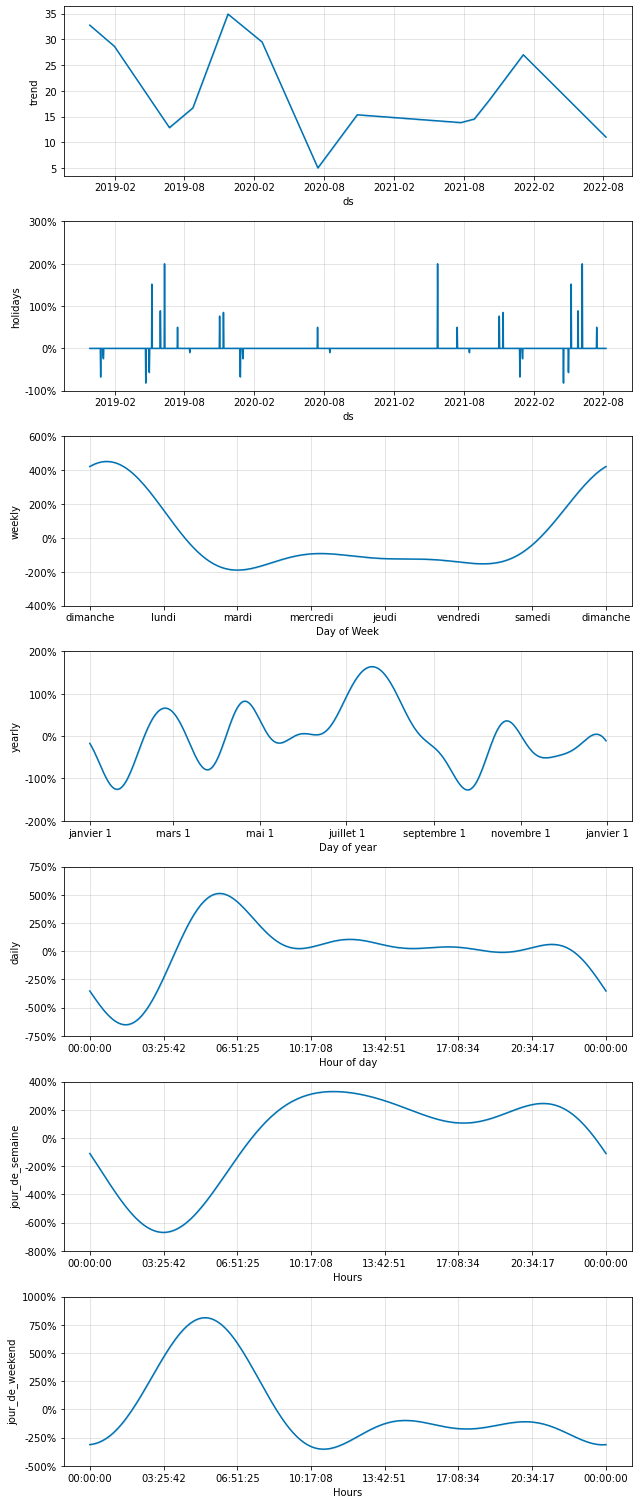

In [54]:
fig2 = model.plot_components(forecast)

#### Prévisions

In [64]:
# Creation du jeu de données 'futur'
future = model.make_future_dataframe(periods = 300, freq = "D")
future['weekend'] = future['ds'].apply(is_weekend)
future['weekday'] = ~future['ds'].apply(is_weekend)

In [65]:
forecast2 = model.predict(future)

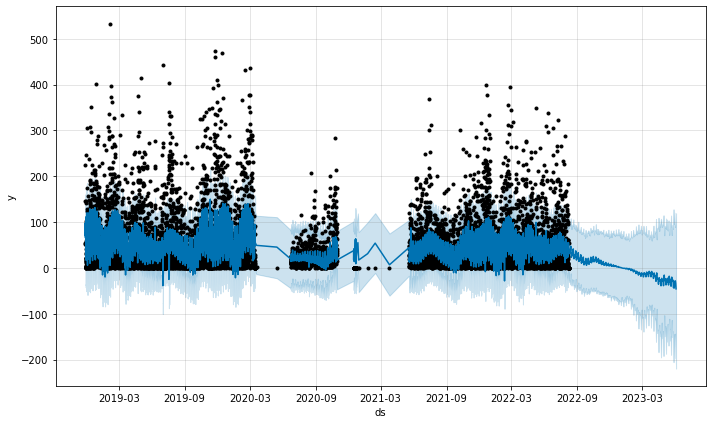

In [66]:
fig3 = model.plot(forecast2)